In [1]:
import numpy as np
import pandas as pd
import random

from pathlib import Path
#from tqdm import tqdm

#import torchaudio
from sklearn.model_selection import train_test_split
from sklearn import *
from scipy import stats
import os
import sys
#import tensorflow_hub as hub
import librosa
import csv

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
import struct

2023-04-18 15:18:29.090270: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-18 15:18:29.091796: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-18 15:18:29.117987: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-18 15:18:29.118573: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 15:18:29.590284: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
data = pd.read_csv("/home/yangya/桌面/project/train_metadata.csv/train_metadata.csv",engine='python')
data.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,abethr1,[],['song'],4.3906,38.2788,Turdus tephronotus,African Bare-eyed Thrush,Rolf A. de By,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/128013,abethr1/XC128013.ogg
1,abethr1,[],['call'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363501,abethr1/XC363501.ogg
2,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363502,abethr1/XC363502.ogg
3,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/363503,abethr1/XC363503.ogg
4,abethr1,[],"['call', 'song']",-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,4.5,https://www.xeno-canto.org/363504,abethr1/XC363504.ogg


In [3]:
#split the data into train data and test data
train_df, test_df = train_test_split(data, test_size=0.2, random_state=101)

In [4]:
import librosa
#import librosa.display
import matplotlib.pyplot as plt

# 加载一个音频文件
file_prefix = "/home/yangya/桌面/project/train_audio/"
idx = 20
sample = data.iloc[idx]
path = file_prefix + sample["filename"]
y, sr = librosa.load(path)
rms1 = librosa.feature.rms(y=y, frame_length=1024, hop_length=1024)
zcr1 = librosa.feature.zero_crossing_rate(y=y,frame_length = 1024, hop_length = 1024)

In [5]:
print(rms1.shape)
print(zcr1.shape)
print(rms1[0])
print(zcr1)

(1, 498)
(1, 498)
[0.00011188 0.01010865 0.00770567 0.00634545 0.0064354  0.00613162
 0.00656    0.00690279 0.00529009 0.00575443 0.00669257 0.00488176
 0.0061506  0.01028865 0.00959178 0.01065298 0.00571191 0.01010204
 0.00814294 0.00590289 0.00954296 0.00519642 0.00638246 0.00865014
 0.0072646  0.01090551 0.006196   0.00516398 0.00741739 0.00652963
 0.00696347 0.0062986  0.00602678 0.00634985 0.00836614 0.01410831
 0.02287667 0.01721435 0.01349906 0.0080961  0.01036538 0.01059781
 0.01242277 0.01038629 0.00881181 0.01028331 0.0117668  0.00826156
 0.00894167 0.00849277 0.00954191 0.01309874 0.01093185 0.0095668
 0.01817344 0.02861225 0.01863299 0.01668461 0.01681875 0.00931463
 0.01138381 0.00808396 0.01275137 0.00917961 0.00617674 0.00867026
 0.01013478 0.00806892 0.01688129 0.0061493  0.00777326 0.00587675
 0.00635502 0.00791334 0.01488486 0.02830406 0.02410529 0.02877182
 0.0198619  0.02413769 0.04045697 0.02370648 0.010578   0.0196203
 0.03711903 0.02219211 0.01975424 0.01510669 0

In [12]:
def truncate_pad(data,length_):
    if len(data)<length_:
        #print(data.shape)
        padded_array = list(data)+ [0] * (length_ - len(data))
        return np.array(padded_array)
    elif len(data)>length_:
        return data[:length_]
    else: return data

In [7]:
def compute_rms(data):
    rms_res = []
    length_ = []
    file_prefix = "/home/yangya/桌面/project/train_audio/"
    for i in range(len(data)):
        idx =i 
        sample = data.iloc[idx]
        path = file_prefix + sample["filename"]
        y, sr = librosa.load(path)
        rms=  librosa.feature.rms(y=y, frame_length=1024, hop_length=1024)
        #temp = truncate_pad(rms[0],2048)
        rms_res.append(rms[0])
        length_.append(len(rms[0]))
    return rms_res,length_

In [8]:
#get the mfccs feature 
train_rms,length1 = compute_rms(train_df)
test_rms,length2 = compute_rms(test_df)

In [9]:
print(length2)

[1329, 295, 371, 640, 602, 13, 526, 193, 568, 587, 60, 585, 541, 380, 394, 1562, 578, 686, 799, 91, 2959, 4071, 332, 2781, 296, 729, 347, 146, 1241, 766, 782, 327, 1255, 178, 4467, 135, 621, 249, 426, 208, 707, 843, 592, 497, 541, 1783, 543, 1079, 319, 1337, 1626, 866, 340, 399, 114, 814, 1489, 224, 2503, 71, 302, 199, 1209, 211, 504, 784, 282, 1192, 1778, 1883, 1833, 213, 1277, 206, 188, 337, 1123, 148, 152, 194, 508, 449, 80, 289, 352, 876, 148, 393, 442, 751, 663, 295, 568, 664, 325, 224, 1044, 300, 80, 241, 474, 391, 325, 583, 705, 1033, 366, 1413, 280, 465, 560, 359, 819, 88, 845, 1239, 2328, 687, 290, 980, 60, 286, 1541, 1864, 1274, 3130, 353, 612, 157, 659, 448, 367, 736, 669, 360, 331, 552, 215, 3777, 927, 4447, 55, 346, 303, 472, 609, 134, 1206, 98, 436, 88, 193, 1192, 367, 161, 1292, 437, 1230, 289, 988, 1962, 4318, 711, 1119, 1920, 2599, 237, 490, 4127, 755, 731, 738, 476, 113, 144, 666, 13951, 2453, 121, 280, 491, 679, 158, 152, 828, 85, 1842, 498, 389, 243, 854, 171, 2910,

In [10]:
def pad_or_cut(data,length):
    res = []
    for i in range(len(data)):
        res1=truncate_pad(data[i],length)
        res.append(res1)
    return res

In [13]:
train_res = np.array(pad_or_cut(train_rms,800))
test_res = np.array(pad_or_cut(test_rms,800))

## The visualization of the length of rms in traindata and testdata

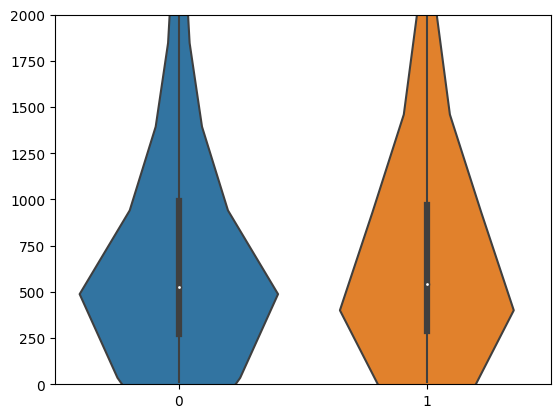

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
df2_22=[]
df2_22.append(length1)
df2_22.append(length2)
#m = [2,3,4,5,6,7,8,9]

fig,ax = plt.subplots()
#df_1 = pd.DataFrame(c)
sns.violinplot(ax=ax, data=df2_22)
plt.ylim(0,2000)
plt.show()

In [19]:
tagnames = data["primary_label"].unique()

In [20]:
# convert list of tags into binary class labels
def tags2class(tags, tagnames):
    b = np.zeros(shape=(len(tags), len(tagnames)))
    for i,t in enumerate(tags):
        for j,n in enumerate(tagnames):
            if n in t:
                b[i,j] = 1
    return b

In [21]:
# train_classes[i,j] = absence/presence of the j-th tag in the i-th sound
train_classes_ = tags2class(train_df['primary_label'], tagnames)
test_classes_ = tags2class(test_df['primary_label'], tagnames)

In [22]:
# generate fixed validation set of 10% of the training set
vtrainI, validI, vtrainYb, validYb = \
  model_selection.train_test_split(train_res , train_classes_ , 
  train_size=0.9, test_size=0.1, random_state=4488)

# make validation data
validsetI = (validI, validYb)

print(np.array(vtrainI).shape)
print(np.array(validI).shape)

(12196, 800)
(1356, 800)


In [23]:
print(len(vtrainI[0]))
print(len(vtrainI[8]))

800
800


In [24]:
def plot_history(history): 
    fig, ax1 = plt.subplots()
    
    ax1.plot(history.history['loss'], 'r', label="training loss ({:.6f})".format(history.history['loss'][-1]))
    ax1.plot(history.history['val_loss'], 'r--', label="validation loss ({:.6f})".format(history.history['val_loss'][-1]))
    ax1.grid(True)
    ax1.set_xlabel('iteration')
    ax1.legend(loc="best", fontsize=9)    
    ax1.set_ylabel('loss', color='r')
    ax1.tick_params('y', colors='r')

    
    if 'accuracy' in history.history:
        ax2 = ax1.twinx()

        ax2.plot(history.history['accuracy'], 'b', label="training acc ({:.4f})".format(history.history['accuracy'][-1]))
        ax2.plot(history.history['val_accuracy'], 'b--', label="validation acc ({:.4f})".format(history.history['val_accuracy'][-1]))

        ax2.legend(loc="best", fontsize=9)
        ax2.set_ylabel('acc', color='b')        
        ax2.tick_params('y', colors='b')

# MLP (512 - 256 - 64 - 264) with learning-rate = 0.001 and momentum =0

Epoch 16: early stopping


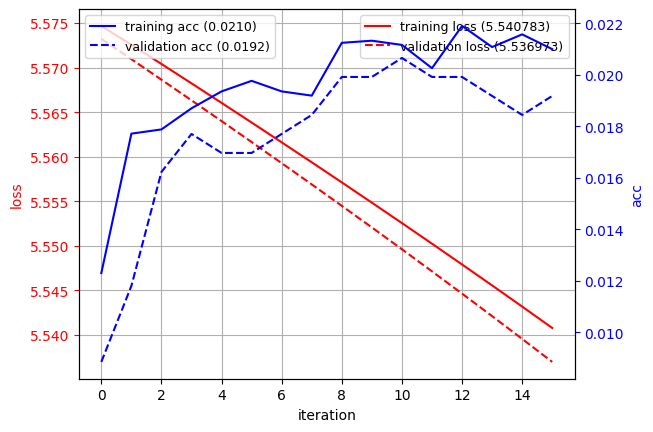

In [35]:

K.clear_session()
random.seed(4487); tf.random.set_seed(4487)

nn = Sequential()
##nn.add(Flatten(input_shape=(19,19,1)))        # input layer flatterning
nn.add(Dense(units=512, input_dim=800, activation='relu')) # hidden layer 1
nn.add(Dense(units=256, input_dim=800, activation='relu')) # hidden layer 2
nn.add(Dense(units=64, input_dim=800, activation='relu')) # hidden layer 3
nn.add(Dense(units=264, activation='softmax')) # output layer

# early stopping criteria
earlystop = keras.callbacks.EarlyStopping(
               monitor='val_accuracy',      # use validation accuracy for stopping
               min_delta=0.0001, patience=5, 
               verbose=1, mode='auto')
callbacks_list = [earlystop]

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy, 
           optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0, nesterov=True),
           metrics=['accuracy'])

history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=64,
                 callbacks=callbacks_list,validation_data=validsetI, verbose=False)


plot_history(history)



In [40]:
predY = nn.predict(test_res, verbose=False) 
predYs=[]
for i in range(len(predY)):
    predYs.append(np.argmax(predY[i]))
len1 = len(predYs)
predYs.append(263)
predY1= keras.utils.to_categorical(predYs)
acc = metrics.accuracy_score(test_classes_, np.array(predY1[:len1])) 
print("test accuracy:", acc)

test accuracy: 0.020064915904396578


# MLP (512 - 256 - 64 - 264) with learning-rate = 0.001 and momentum =0.9

Epoch 12: early stopping


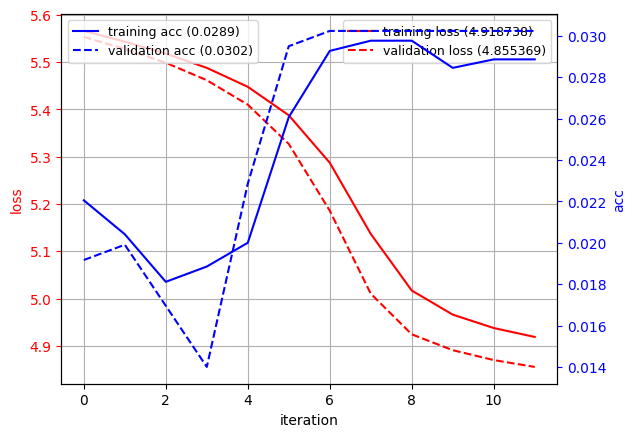

In [41]:

K.clear_session()
random.seed(4487); tf.random.set_seed(4487)

nn = Sequential()
##nn.add(Flatten(input_shape=(19,19,1)))        # input layer flatterning
nn.add(Dense(units=512, input_dim=800, activation='relu')) # hidden layer 1
nn.add(Dense(units=256, input_dim=800, activation='relu')) # hidden layer 2
nn.add(Dense(units=64, input_dim=800, activation='relu')) # hidden layer 3
nn.add(Dense(units=264, activation='softmax')) # output layer

# early stopping criteria
earlystop = keras.callbacks.EarlyStopping(
               monitor='val_accuracy',      # use validation accuracy for stopping
               min_delta=0.0001, patience=5, 
               verbose=1, mode='auto')
callbacks_list = [earlystop]

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy, 
           optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True),
           metrics=['accuracy'])

history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=64,
                 callbacks=callbacks_list,validation_data=validsetI, verbose=False)


plot_history(history)



In [42]:
predY = nn.predict(test_res, verbose=False) 
predYs=[]
for i in range(len(predY)):
    predYs.append(np.argmax(predY[i]))
len1 = len(predYs)
predYs.append(263)
predY1= keras.utils.to_categorical(predYs)
acc = metrics.accuracy_score(test_classes_, np.array(predY1[:len1])) 
print("test accuracy:", acc)

test accuracy: 0.027441723222189435


# MLP (512 - 256 - 64 - 264) with learning-rate = 0.01 and momentum =0.9

Epoch 17: early stopping


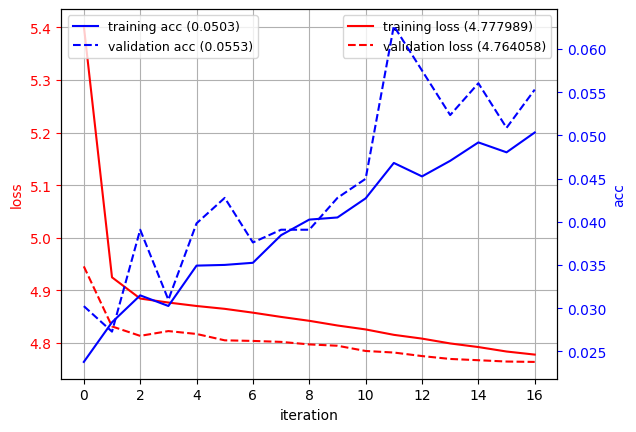

In [43]:

K.clear_session()
random.seed(4487); tf.random.set_seed(4487)

nn = Sequential()
##nn.add(Flatten(input_shape=(19,19,1)))        # input layer flatterning
nn.add(Dense(units=512, input_dim=800, activation='relu')) # hidden layer 1
nn.add(Dense(units=256, input_dim=800, activation='relu')) # hidden layer 2
nn.add(Dense(units=64, input_dim=800, activation='relu')) # hidden layer 3
nn.add(Dense(units=264, activation='softmax')) # output layer

# early stopping criteria
earlystop = keras.callbacks.EarlyStopping(
               monitor='val_accuracy',      # use validation accuracy for stopping
               min_delta=0.0001, patience=5, 
               verbose=1, mode='auto')
callbacks_list = [earlystop]

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy, 
           optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
           metrics=['accuracy'])

history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=64,
                 callbacks=callbacks_list,validation_data=validsetI, verbose=False)


plot_history(history)



In [44]:
predY = nn.predict(test_res, verbose=False) 
predYs=[]
for i in range(len(predY)):
    predYs.append(np.argmax(predY[i]))
len1 = len(predYs)
predYs.append(263)
predY1= keras.utils.to_categorical(predYs)
acc = metrics.accuracy_score(test_classes_, np.array(predY1[:len1])) 
print("test accuracy:", acc)

test accuracy: 0.042195337857775156


# MLP (512 - 256 - 64 - 264) with learning-rate = 0.1 and momentum =0.9

Epoch 14: early stopping


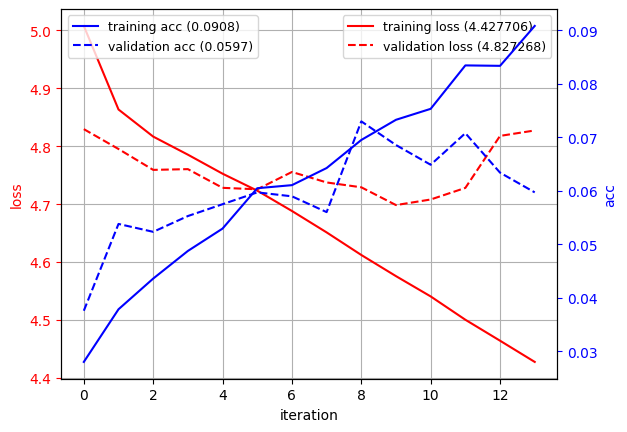

In [45]:

K.clear_session()
random.seed(4487); tf.random.set_seed(4487)

nn = Sequential()
##nn.add(Flatten(input_shape=(19,19,1)))        # input layer flatterning
nn.add(Dense(units=512, input_dim=800, activation='relu')) # hidden layer 1
nn.add(Dense(units=256, input_dim=800, activation='relu')) # hidden layer 2
nn.add(Dense(units=64, input_dim=800, activation='relu')) # hidden layer 3
nn.add(Dense(units=264, activation='softmax')) # output layer

# early stopping criteria
earlystop = keras.callbacks.EarlyStopping(
               monitor='val_accuracy',      # use validation accuracy for stopping
               min_delta=0.0001, patience=5, 
               verbose=1, mode='auto')
callbacks_list = [earlystop]

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy, 
           optimizer=keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True),
           metrics=['accuracy'])

history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=64,
                 callbacks=callbacks_list,validation_data=validsetI, verbose=False)


plot_history(history)



In [46]:
predY = nn.predict(test_res, verbose=False) 
predYs=[]
for i in range(len(predY)):
    predYs.append(np.argmax(predY[i]))
len1 = len(predYs)
predYs.append(263)
predY1= keras.utils.to_categorical(predYs)
acc = metrics.accuracy_score(test_classes_, np.array(predY1[:len1])) 
print("test accuracy:", acc)

test accuracy: 0.052817940395396876


# MLP (512 - 256 - 64 - 264) with learning-rate = 0.1, momentum =0.9 and patience = 10

Epoch 19: early stopping


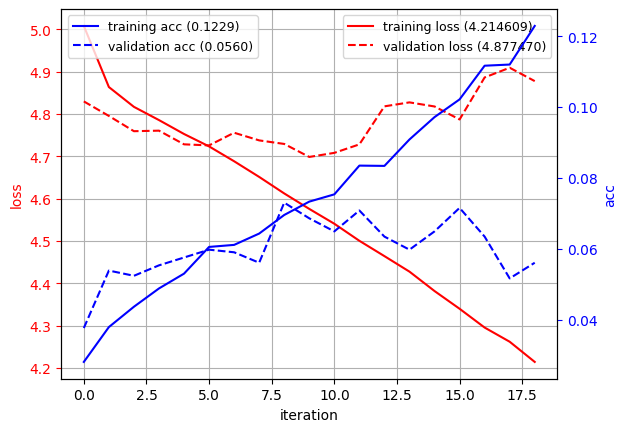

In [47]:

K.clear_session()
random.seed(4487); tf.random.set_seed(4487)

nn = Sequential()
##nn.add(Flatten(input_shape=(19,19,1)))        # input layer flatterning
nn.add(Dense(units=512, input_dim=800, activation='relu')) # hidden layer 1
nn.add(Dense(units=256, input_dim=800, activation='relu')) # hidden layer 2
nn.add(Dense(units=64, input_dim=800, activation='relu')) # hidden layer 3
nn.add(Dense(units=264, activation='softmax')) # output layer

# early stopping criteria
earlystop = keras.callbacks.EarlyStopping(
               monitor='val_accuracy',      # use validation accuracy for stopping
               min_delta=0.0001, patience=10, 
               verbose=1, mode='auto')
callbacks_list = [earlystop]

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy, 
           optimizer=keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True),
           metrics=['accuracy'])

history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=64,
                 callbacks=callbacks_list,validation_data=validsetI, verbose=False)


plot_history(history)



In [48]:
predY = nn.predict(test_res, verbose=False) 
predYs=[]
for i in range(len(predY)):
    predYs.append(np.argmax(predY[i]))
len1 = len(predYs)
predYs.append(263)
predY1= keras.utils.to_categorical(predYs)
acc = metrics.accuracy_score(test_classes_, np.array(predY1[:len1])) 
print("test accuracy:", acc)

test accuracy: 0.05606373561522573
